In [1]:
import sys
sys.path.append("../scripts/")
from robot import *
from scipy.stats import multivariate_normal

In [2]:
class Particle:
    def __init__(self, init_pose):
        self.pose = init_pose
    
    def motion_update(self, nu, omega, time, noise_rate_pdf):
        ns = noise_rate_pdf.rvs()
        noised_nu = nu + ns[0] * math.sqrt(abs(nu)/time) + ns[1] * math.sqrt(abs(omega)/time)
        noised_omega = omega + ns[2] * math.sqrt(abs(nu)/time) + ns[3] * math.sqrt(abs(omega)/time)
        self.pose = IdealRobot.state_transition(noised_nu, noised_omega, time, self.pose)
        
    def observation_update(self, observation):
        print(observation)


In [3]:
class Mcl:
    def __init__(self, init_pose, num, motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        self.particles = [Particle(init_pose) for i in range(num)]
        
        v = motion_noise_stds
        c = np.diag([v["nn"]**2, v["no"]**2, v["on"]**2, v["oo"]**2])
        self.motion_noise_rate_pdf = multivariate_normal(cov=c)
        
    def motion_update(self, nu, omega, time):
        for p in self.particles:
            p.motion_update(nu, omega, time, self.motion_noise_rate_pdf)
    
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation)
        
    def draw(self, ax, elems):
        xs = [p.pose[0] for p in self.particles]
        ys = [p.pose[1] for p in self.particles]
        vxs = [math.cos(p.pose[2]) for p in self.particles]
        vys = [math.sin(p.pose[2]) for p in self.particles]
        elems.append(ax.quiver(xs, ys, vxs, vys, color="blue", alpha=0.5))

In [4]:
class EstimationAgent(Agent):
    def __init__(self, time_interval, nu, omega, estimator):
        super().__init__(nu, omega)
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0.0
        self.prev_omega = 0.0
    
    def decision(self, observation=None):
        self.estimator.motion_update(self.prev_nu, self.prev_omega, self.time_interval)
        self.prev_nu, self.prev_omega = self.nu, self.omega
        self.estimator.observation_update(observation)
        return self.nu, self.omega
        
    def draw(self, ax, elems):
        self.estimator.draw(ax, elems)

In [5]:
initial_pose = np.array([0, 0, 0]).T
estimator = Mcl(initial_pose, 100, motion_noise_stds={"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})
estimator.motion_update(0.2, 10.0/180*math.pi, 0.1)
for p in estimator.particles:
    print(p.pose)

[0.01829585 0.00011332 0.0123876 ]
[0.01884594 0.00014705 0.01560491]
[0.01958923 0.00012863 0.01313232]
[0.01937562 0.00011003 0.01135792]
[0.0188834  0.00013966 0.01479179]
[0.01802564 0.00018222 0.0202176 ]
[0.01739059 0.00012534 0.01441397]
[0.02339288 0.00028031 0.02396458]
[1.78403420e-02 5.28378959e-05 5.92340005e-03]
[0.01799694 0.00010089 0.01121227]
[1.58795285e-02 9.81514319e-05 1.23618509e-02]
[0.01490478 0.00021554 0.02892065]
[0.02101048 0.00018015 0.01714805]
[0.01859794 0.00018234 0.01960799]
[0.02413572 0.00020403 0.01690664]
[0.01605699 0.00011251 0.01401311]
[0.01765791 0.0001361  0.01541468]
[0.02453134 0.00024026 0.01958759]
[0.02104349 0.00017672 0.0167951 ]
[0.01665654 0.00021029 0.02524827]
[0.01738311 0.00016275 0.01872507]
[0.02126083 0.00032288 0.03037088]
[0.01879501 0.0001555  0.01654615]
[0.02319335 0.00031592 0.02724103]
[0.01990431 0.00026124 0.02624849]
[0.02198177 0.00016267 0.01479999]
[0.0246701  0.00025097 0.02034549]
[0.02132308 0.00010606 0.009947

<IPython.core.display.Javascript object>


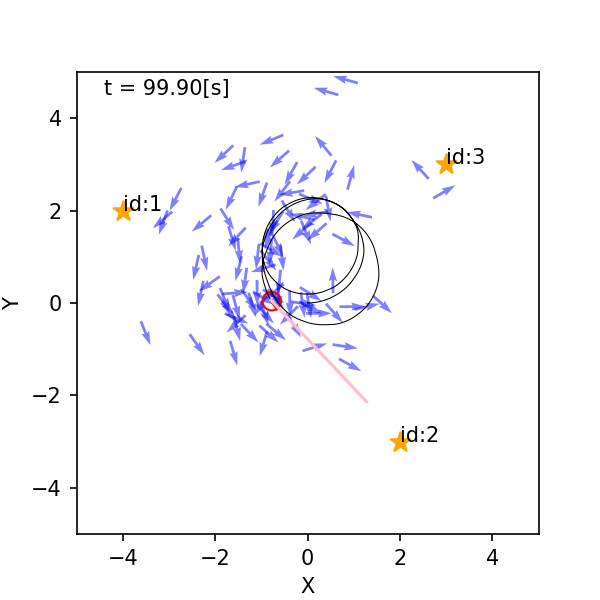

<IPython.core.display.Javascript object>


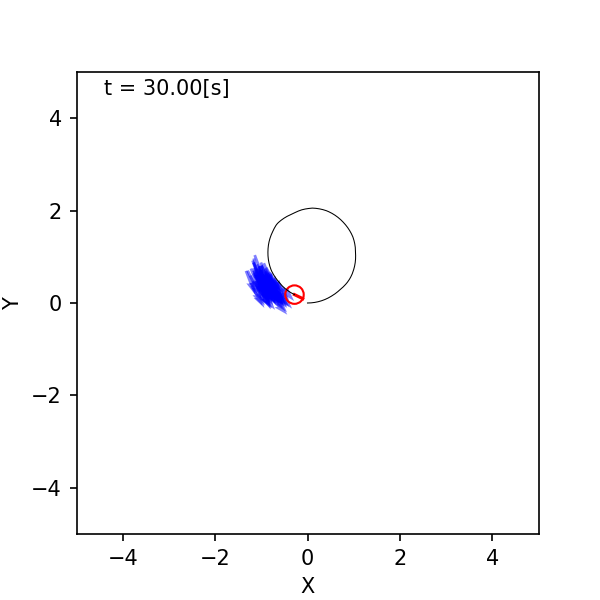

In [18]:
def trial(motion_noise_stds):
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100, motion_noise_stds)
    circling = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=None, agent=circling, color="red")
    world.append(r)
    
    world.draw()

trial({"nn":0.01, "no":0.02, "on":0.03, "oo":0.04})

<IPython.core.display.Javascript object>


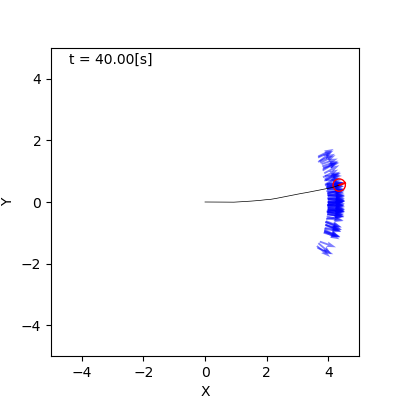

In [16]:
def test_particle_filter():
    time_interval = 0.1
    world = World(40, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    # motion_test_forward.ipynb で求めた標準偏差ωνをパーティクルに適用(その他は0扱い)
    motion_noise_stds = {"nn": 0.001, "no":0.001, "on": 0.13, "oo":0.001}
    e = Mcl(initial_pose, 100, motion_noise_stds)
    a = EstimationAgent(time_interval, 0.1, 0.0, e)
    r = Robot(initial_pose, sensor=None, agent=a, color='red')
    world.append(r)
    
    world.draw()

test_particle_filter()

<IPython.core.display.Javascript object>


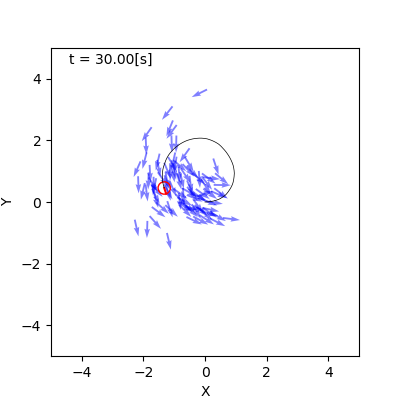

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [12]:
# 走行させた robot の統計結果から求めた標準偏差を考慮した雑音を適用したパーティクルの確認
def trial2():
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    e = Mcl(initial_pose, 100)
    c = EstimationAgent(time_interval, 0.2, 10/180*math.pi, e)
    r = Robot(initial_pose, sensor=None, agent=c, color='red')
    world.append(r)
    
    world.draw()

trial2()

<IPython.core.display.Javascript object>


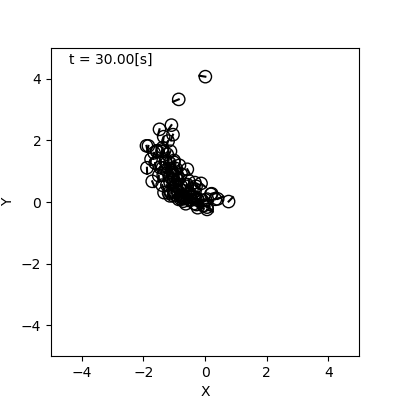

In [9]:
# パーティクルとの比較用: 100台の robot を回転
def rot_robots
    time_interval = 0.1
    world = World(30, time_interval, debug=False)
    
    initial_pose = np.array([0, 0, 0]).T
    for i in range(100):
        r = Robot(initial_pose, sensor=None, agent=Agent(0.2, 10/180*math.pi), orbit=False)
        world.append(r)
        
    world.draw()

    
rot_robots()

In [17]:
# センサの観測情報をパーティクルに反映
def trial3():
    time_interval = 0.1
    world = World(30, time_interval, debug=True)
    
    m = Map()
    for ln in [(-4,2), (2,-3), (3,3)]:
        m.append_landmark(Landmark(*ln))
    world.append(m)
    
    initial_pose = np.array([0, 0, 0]).T
    estimator = Mcl(initial_pose, 100)
    a = EstimationAgent(time_interval, 0.2, 10.0/180*math.pi, estimator)
    r = Robot(initial_pose, sensor=Camera(m), agent=a, color='red')
    world.append(r)
    
    world.draw()
    
trial3()

[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.33637087, 0.73899505]), 3)]
[(array([ 2.81505237, -1.02331865]), 2), (array([3.3

[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.34841802, 0.71576538]), 3)]
[(array([ 2.59144691, -1.05048933]), 2), (array([3.3

[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78220612]), 3)]
[(array([3.31263149, 0.78

[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[(array([3.07441662, 0.65312189]), 3)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.07880853, 0.67115663]), 3)]
[(array([3.07880853, 0.67115663]), 3)]
[(array([3.07880853, 0.67115663]), 3)]
[(array([3.07880853, 0.67115663]), 3)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.34928563, 0.55346937]), 3)]
[(array([3.34928563, 0.55346937]), 3)]
[(array([3.34928563, 0.55346937]), 3)]
[(array([3.34928563, 0.55346937]), 3)]
[(array([3.34928563, 0.55346937]), 3)]
[(array([3.34928563, 0.55346

[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44845095]), 3)]
[(array([3.08925666, 0.44

[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40535643]), 3)]
[(array([3.67282679, 0.40

[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44553822]), 3)]
[(array([3.28305441, 0.44

[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36836671]), 3)]
[(array([2.75666919, 0.36

[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32453814]), 3)]
[(array([3.20668511, 0.32

[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19244147]), 3)]
[(array([2.46745951, 0.19

[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19945542]), 3)]
[(array([2.95655365, 0.19

[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09087405]), 3)]
[(array([2.53645889, 0.09

[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06080845]), 3)]
[(array([2.93267205, 0.06

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]
[(array([ 2.54515347, -0.0031398 ]), 3)]

[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.37801083, -0.049492  ]), 3)]
[(array([ 2.3780

[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.43579193, -0.0902609 ]), 3)]
[(array([ 2.4357

[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.63308126, -0.08781796]), 3)]
[(array([ 2.6330

[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.20481384, -0.19695448]), 3)]
[(array([ 2.2048

[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.28259681, -0.21694254]), 3)]
[(array([ 2.2825

[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.08193082, -0.30621103]), 3)]
[(array([ 2.0819

[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525792 , -0.30612699]), 3)]
[(array([ 2.2525

[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.02974977, -0.36664747]), 3)]
[(array([ 2.0297

[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.47184524, -0.44723697]), 3)]
[(array([ 2.4718

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(array([ 2.53091552, -0.57745741]), 3)]
[(a

[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.07594784, -0.57428826]), 3)]
[(array([ 2.0759

[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.28215518, -0.68219376]), 3)]
[(array([ 2.2821

[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.89321949, -0.91806704]), 3)]
[(array([ 1.8932

[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.89150436, -0.95223642]), 3)]
[(array([ 1.8915

[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.97449655, -0.98077682]), 3)]
[(array([ 1.9744

[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.10062824, -1.09567318]), 3)]
[(array([ 2.1006

[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.0080132 ]), 1)]
[(array([3.73177757, 1.00

[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.18590775, 0.95087672]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97546785]), 1)]
[(array([4.57953448, 0.97

[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.9065271 ]), 1)]
[(array([4.07500096, 0.90

[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([3.94934281, 0.84225815]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85791152]), 1)]
[(array([4.32820801, 0.85

[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90930346]), 1)]
[(array([3.95243072, 0.90

[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88009867]), 1)]
[(array([4.08536478, 0.88

[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85435345]), 1)]
[(array([3.76709809, 0.85

[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84089895]), 1)]
[(array([4.24888871, 0.84

[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([3.42865773, 0.79021857]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75198127]), 1)]
[(array([4.20983749, 0.75

[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59991963]), 1)]
[(array([3.97768136, 0.59

[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54496781]), 1)]
[(array([3.68131019, 0.54

[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50941248]), 1)]
[(array([3.81950553, 0.50

[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42193435]), 1)]
[(array([3.48939246, 0.42

[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27278249]), 1)]
[(array([3.26094142, 0.27

[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22650815]), 1)]
[(array([3.82247058, 0.22

[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22678998]), 1)]
[(array([3.39950388, 0.22

[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16900282]), 1)]
[(array([3.68940314, 0.16

[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08258723]), 1)]
[(array([2.92960567, 0.08

[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04224402]), 1)]
[(array([4.15868718, 0.04

[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.36531204, -0.03539352]), 1)]
[(array([ 3.3653

[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.58318775, -0.08550883]), 1)]
[(array([ 3.5831

[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.47603319, -0.10299335]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.99984052, -0.16802599]), 1)]
[(array([ 2.9998

[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.57140561, -0.18913257]), 1)]
[(array([ 3.5714

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(array([ 3.26870413, -0.2868745 ]), 1)]
[(a

[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.91260764, -0.2819867 ]), 1)]
[(array([ 2.9126

[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.96522831, -0.40786446]), 1)]
[(array([ 2.9652

[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.02507969, -0.51803281]), 1)]
[(array([ 3.0250

[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.89434994, -0.50307489]), 1)]
[(array([ 2.8943

[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.36542745, -0.56613895]), 1)]
[(array([ 3.3654

[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.11330277, -0.77126649]), 1)]
[(array([ 3.1133

[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.42724539, -0.84493523]), 1)]
[(array([ 2.4272

[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.94983685, -0.87997278]), 1)]
[(array([ 2.9498

[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139718 , -0.92555556]), 1)]
[(array([ 2.7139

[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.268833  , -0.96738324]), 1)]
[(array([ 2.2688

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94617302]), 2)]
[(array([4.53917446, 0.94

[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89521403]), 2)]
[(array([4.00324869, 0.89

[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90127664]), 2)]
[(array([4.1224368 , 0.90

[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82500236]), 2)]
[(array([3.9594437 , 0.82

[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76978818]), 2)]
[(array([4.32364657, 0.76

[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.20677343, 0.77579452]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77187301]), 2)]
[(array([4.53614003, 0.77

[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78607571]), 2)]
[(array([4.11232542, 0.78

[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64383248]), 2)]
[(array([3.99315698, 0.64

[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64257978]), 2)]
[(array([3.93119817, 0.64

[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53666243]), 2)]
[(array([3.68427884, 0.53

[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52637161]), 2)]
[(array([3.62158024, 0.52

[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([3.91405397, 0.5178299 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.4424589 ]), 2)]
[(array([4.30137354, 0.44

[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34633172]), 2)]
[(array([3.72408064, 0.34

[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.3089119 ]), 2)]
[(array([3.55587598, 0.30

[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33723362]), 2)]
[(array([3.96128844, 0.33

[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28616824]), 2)]
[(array([4.03748722, 0.28

[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([4.09084526, 0.10885918]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17254818]), 2)]
[(array([3.22769989, 0.17

[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.56116616, -0.03553201]), 2)]
[(array([ 3.5611

[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.93813474, -0.04140547]), 2)]
[(array([ 3.9381

[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.23438066, -0.16612545]), 2)]
[(array([ 4.2343

[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.17606254, -0.16612352]), 2)]
[(array([ 3.1760

[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.39735561, -0.20346125]), 2)]
[(array([ 3.3973

[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.21984565, -0.30558918]), 2)]
[(array([ 4.2198

[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.31803449, -0.31931899]), 2)]
[(array([ 3.3180

[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.73344869, -0.45810775]), 2)]
[(array([ 3.7334

[(array([ 3.2628407, -0.4706929]), 2)]
[(array([ 3.2628407, -0.4706929]), 2)]
[(array([ 3.2628407, -0.4706929]), 2)]
[(array([ 3.2628407, -0.4706929]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0.56120642]), 2)]
[(array([ 3.74238523, -0

[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.58160761, -0.54937521]), 2)]
[(array([ 3.5816

[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.66266815, 0.96548449]), 3)]
[(array([ 3.02091584, -0.64959603]), 2), (array([3.6

[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91065635]), 3)]
[(array([2.74451027, 0.91

[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.96488785, 0.93523574]), 3)]
[(array([ 3.43353477, -0.77431215]), 2), (array([2.9

[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.13924575, 0.86440485]), 3)]
[(array([ 3.06336544, -0.86279304]), 2), (array([3.1

[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.44291273, -0.9473914 ]), 2)]
[(array([ 3.4429

[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.76650133, 0.77433781]), 3)]
[(array([ 2.90975539, -0.946436  ]), 2), (array([2.7

[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.67696051, 0.69953004]), 3)]
[(array([ 3.29487387, -1.04783709]), 2), (array([3.6

[(array([3.54532719, 0.65297723]), 3)]
[(array([3.54532719, 0.65297723]), 3)]
[(array([3.54532719, 0.65297723]), 3)]
[(array([3.54532719, 0.65297723]), 3)]
[(array([3.54532719, 0.65297723]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70866702]), 3)]
[(array([2.42256408, 0.70

[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65740203]), 3)]
[(array([3.4742259 , 0.65

[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59540357]), 3)]
[(array([3.50008206, 0.59

[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56872738]), 3)]
[(array([3.46367954, 0.56

[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52915123]), 3)]
[(array([2.80021521, 0.52

[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43881542]), 3)]
[(array([3.62812587, 0.43

[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.3495402 ]), 3)]
[(array([3.16167307, 0.34

[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43995447]), 3)]
[(array([3.23916121, 0.43

[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41128188]), 3)]
[(array([2.98641525, 0.41

[(array([2.9370693, 0.2688708]), 3)]
[(array([2.9370693, 0.2688708]), 3)]
[(array([2.9370693, 0.2688708]), 3)]
[(array([2.9370693, 0.2688708]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545]), 3)]
[(array([2.88698316, 0.29153545])

[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19881016]), 3)]
[(array([2.51309528, 0.19

[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15898394]), 3)]
[(array([2.81052188, 0.15

[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09464505]), 3)]
[(array([2.40442255, 0.09

[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09179443]), 3)]
[(array([2.74268825, 0.09

[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([2.37895981, 0.03429433]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]), 3)]
[(array([ 2.74187109, -0.04934743]

[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02791893]), 3)]
[(array([2.46809802, 0.02

[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.59157607, -0.08248865]), 3)]
[(array([ 2.5915

[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.55970458, -0.17285347]), 3)]
[(array([ 2.74041648, -0.13064698]), 3)]
[(array([ 2.74041648, -0.13064698]), 3)]
[(array([ 2.74041648, -0.13064698]), 3)]
[(array([ 2.74041648, -0.13064698]), 3)]
[(array([ 2.74041648, -0.13064698]), 3)]
[(array([ 2.7404

[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.25591541, -0.24144538]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.38717682, -0.26085887]), 3)]
[(array([ 2.3871

[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.19543961, -0.24280562]), 3)]
[(array([ 2.1954

[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.57220239, -0.41961551]), 3)]
[(array([ 2.5722

[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.11587556, -0.54274414]), 3)]
[(array([ 2.1158

[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.27648276, -0.56127748]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.66401533, -0.61053943]), 3)]
[(array([ 2.6640

[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.23692914, -0.68573074]), 3)]
[(array([ 2.2369

[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.99849967, -0.71058123]), 3)]
[(array([ 1.9984

[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252074 , -0.84030068]), 3)]
[(array([ 2.1252

[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607897 , -0.84733327]), 3)]
[(array([ 1.9607

[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.14560895, -0.79705534]), 3)]
[(array([ 2.1456

[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982558 , -0.84979306]), 3)]
[(array([ 1.9982

[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.95103654, -0.97539644]), 3)]
[(array([ 1.9510

[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.81700699, -1.06854359]), 3)]
[(array([ 1.8170

[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02876781]), 1)]
[(array([2.62659885, 1.02

[(array([4.38849889, 0.94314604]), 1)]
[(array([4.38849889, 0.94314604]), 1)]
[(array([4.38849889, 0.94314604]), 1)]
[(array([4.38849889, 0.94314604]), 1)]
[(array([4.38849889, 0.94314604]), 1)]
[(array([4.38849889, 0.94314604]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99653837]), 1)]
[(array([3.71322734, 0.99

[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89152409]), 1)]
[(array([3.64677596, 0.89

[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89871006]), 1)]
[(array([3.77969642, 0.89

[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77104211]), 1)]
[(array([4.15190145, 0.77

[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80506275]), 1)]
[(array([3.66944231, 0.80

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[(array([3.38786787, 0.68436555]), 1)]
[

[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58115532]), 1)]
[(array([3.16755805, 0.58

[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53065701]), 1)]
[(array([3.18679193, 0.53

[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48434653]), 1)]
[(array([4.19722734, 0.48

[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41590853]), 1)]
[(array([3.15177259, 0.41

[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[(array([3.32452634, 0.37833825]), 1)]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.358333]), 1)]
[(array([3.103873, 0.3

[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[(array([3.5047014, 0.2736898]), 1)]
[

[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22953095]), 1)]
[(array([3.54022776, 0.22

[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17832682]), 1)]
[(array([3.27301188, 0.17

[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.19014925, -0.03629077]), 1)]
[(array([ 3.1901

[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.11502442, -0.10310491]), 1)]
[(array([ 3.1150

[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.93289746, -0.07113537]), 1)]
[(array([ 2.9328

[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.40007656, -0.11517716]), 1)]
[(array([ 3.4000

[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.11882194, -0.20059737]), 1)]
[(array([ 3.1188

[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.32915969, -0.19516016]), 1)]
[(array([ 2.3291

[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.34700483, -0.3053462 ]), 1)]
[(array([ 3.3470

[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316102 , -0.40397481]), 1)]
[(array([ 3.0316

[(array([ 2.46671152, -0.37856349]), 1)]
[(array([ 2.46671152, -0.37856349]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.11603934, -0.45370207]), 1)]
[(array([ 3.1160

[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.75283296, -0.41799368]), 1)]
[(array([ 2.7528

[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.46760816, -0.61069808]), 1)]
[(array([ 2.4676

[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.05975131, -0.54429327]), 1)]
[(array([ 3.0597

[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.44434045, -0.72904665]), 1)]
[(array([ 2.4443

[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.17475655, -0.7189096 ]), 1)]
[(array([ 3.1747

[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.06236264, -0.7372425 ]), 1)]
[(array([ 3.0623

[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.55559377, -0.85474764]), 1)]
[(array([ 2.5555

[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.79224826, -0.91231294]), 1)]
[(array([ 2.7922

[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.60313839, -0.96797728]), 1)]
[(array([ 2.6031

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.60088045, -1.06440823]), 1)]
[(array([ 2.6008

[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05666805]), 2)]
[(array([4.59824763, 1.05

[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93910053]), 2)]
[(array([4.55053745, 0.93

[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93898868]), 2)]
[(array([3.5712197 , 0.93

[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83157327]), 2)]
[(array([4.51807614, 0.83

[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89964322]), 2)]
[(array([3.32403371, 0.89

[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90339962]), 2)]
[(array([4.50447239, 0.90

[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.7956311 ]), 2)]
[(array([4.04325337, 0.79

[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.8085504 ]), 2)]
[(array([3.63316461, 0.80

[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73016815]), 2)]
[(array([4.73389174, 0.73

[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60039813]), 2)]
[(array([3.63611292, 0.60

[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([3.43915774, 0.63882886]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56377138]), 2)]
[(array([4.3753948 , 0.56

[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.6014879 ]), 2)]
[(array([4.29365447, 0.60

[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48423942]), 2)]
[(array([3.97330145, 0.48

[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.78542062, 0.43326664]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.4786069 ]), 2)]
[(array([3.03208535, 0.47

[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53265789]), 2)]
[(array([3.21554268, 0.53

[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43198466]), 2)]
[(array([3.18192211, 0.43

[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41252684]), 2)]
[(array([3.90065468, 0.41

[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38695044]), 2)]
[(array([3.61768197, 0.38

[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34136478]), 2)]
[(array([3.89629622, 0.34

[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35612088]), 2)]
[(array([3.61492561, 0.35

[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38260269]), 2)]
[(array([4.26857917, 0.38

[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37671165]), 2)]
[(array([2.64419443, 0.37

[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.2182832 ]), 2)]
[(array([3.00406083, 0.21

[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17966205]), 2)]
[(array([3.78871197, 0.17

[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31873418]), 2)]
[(array([3.01115365, 0.31

[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20756422]), 2)]
[(array([3.28276539, 0.20

[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14693501]), 2)]
[(array([3.37674104, 0.14

[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11143059]), 2)]
[(array([3.21381974, 0.11

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)]
[(array([3.09524523, 0.10720531]), 2)

[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.00405006, -0.01219381]), 2)]
[(array([ 3.0040

[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.86616875, -0.04262468]), 2)]
[(array([ 2.8661

[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.63473441, -0.1186528 ]), 2)]
[(array([ 2.6347

[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.84179351, -0.11073369]), 2)]
[(array([ 2.8417

[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.45642514, -0.2482001 ]), 2)]
[(array([ 2.4564

[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 3.02716151, -0.29660035]), 2)]
[(array([ 2.38505478, -0.23973111]), 2)]
[(array([ 2.3850

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.33864054]), 2)]
[(array([ 2.88261998, -0.338

[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994188 , -0.41570723]), 2)]
[(array([ 2.7994

[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.49981268, -0.40057432]), 2)]
[(array([ 2.4998

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(array([ 2.6640026 , -0.53998628]), 2)]
[(a

[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.00232867, -0.52240467]), 2)]
[(array([ 3.0023

[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.35434482, -0.57307797]), 2)]
[(array([ 2.3543

[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.64512389, -0.6702048 ]), 2)]
[(array([ 2.6451

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476, -0.8005206 ]), 2)]
[(array([ 2.71267476,

[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.57800144, 0.98721585]), 3)]
[(array([ 2.85590097, -0.84011995]), 2), (array([3.5

[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8979479 , 0.97579104]), 3)]
[(array([ 2.46672105, -0.82048319]), 2), (array([3.8

[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.44738372, 0.96383237]), 3)]
[(array([ 2.75587882, -0.91814701]), 2), (array([3.4

[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.58120741, 0.92163811]), 3)]
[(array([ 2.36009688, -0.96270636]), 2), (array([3.5

[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.73405622, 0.91849922]), 3)]
[(array([ 2.29015703, -0.96699306]), 2), (array([3.7

[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.48597693, 0.85571334]), 3)]
[(array([ 2.53898536, -0.96596227]), 2), (array([3.4

[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.12218196, 0.94322122]), 3)]
[(array([ 1.93693557, -0.97905373]), 2), (array([3.1

[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88903849]), 3)]
[(array([3.27056488, 0.88

[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80791948]), 3)]
[(array([3.87022052, 0.80

[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82190224]), 3)]
[(array([3.67555071, 0.82

[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74861931]), 3)]
[(array([3.14928788, 0.74

[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71050933]), 3)]
[(array([2.71753526, 0.71

[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64009143]), 3)]
[(array([3.2330853 , 0.64

[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54461093]), 3)]
[(array([3.06203274, 0.54

[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44576452]), 3)]
[(array([3.09623447, 0.44

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0.38915681]), 3)]
[(array([2.88799033, 0

[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39122298]), 3)]
[(array([3.14524022, 0.39

[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39622034]), 3)]
[(array([2.41627686, 0.39

[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.15921915, 0.25663222]), 3)]
[(array([3.16119721, 0.30137684]), 3)]
[(array([3.16119721, 0.30137684]), 3)]
[(array([3.16119721, 0.30137684]), 3)]
[(array([3.16119721, 0.30137684]), 3)]
[(array([3.16119721, 0.30137684]), 3)]
[(array([3.16119721, 0.30

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)]
[(array([2.46944686, 0.23767183]), 3)

[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08309767]), 3)]
[(array([2.78074191, 0.08

[(array([ 2.78502931, -0.01645134]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.07461229]), 3)]
[(array([2.43809435, 0.

[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.56637063, -0.13331689]), 3)]
[(array([ 2.5663

[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.68748113, -0.16297446]), 3)]
[(array([ 2.6874

[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.57701655, -0.27854388]), 3)]
[(array([ 2.5770

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(array([ 2.20939807, -0.28206856]), 3)]
[(a

[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.28883243, -0.32795405]), 3)]
[(array([ 2.2888

[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.42343549, -0.36212994]), 3)]
[(array([ 2.4234

[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.17036135, -0.4388743 ]), 3)]
[(array([ 2.1703

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(array([ 1.80873593, -0.53017704]), 3)]
[(a

[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 1.98273701, -0.72011226]), 3)]
[(array([ 2.09771124, -0.66899039]), 3)]
[(array([ 2.09771124, -0.66899039]), 3)]
[(array([ 2.09771124, -0.66899039]), 3)]
[(array([ 2.0977

[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.08911223, -0.73082602]), 3)]
[(array([ 2.0891

[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.99027358, -0.75256985]), 3)]
[(array([ 1.9902

[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.14705892, -0.88531997]), 3)]
[(array([ 2.1470

[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.84452672, -0.86431065]), 3)]
[(array([ 1.8445

[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.12697032, -0.92545393]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.00660165, -0.87986801]), 3)]
[(array([ 2.0066

[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 1.8833736 , -0.95023158]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.36101782, -0.95105803]), 3)]
[(array([ 2.3610

[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.96452801, -1.00029346]), 3)]
[(array([ 1.9645

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([4.69362494, 1.07904194]), 1)]
[(array([4.69362494, 1.07904194]), 1)]
[(array([4.69362494, 1.07904194]), 1)]
[(array([4.69362494, 1.07904194]), 1)]
[(array([4.69362494, 1.07904194]),

[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95058948]), 1)]
[(array([4.17142578, 0.95

[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94190661]), 1)]
[(array([4.24618456, 0.94

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80481895]), 1)]
[(array([4.32419042, 0.80

[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82882116]), 1)]
[(array([4.32836195, 0.82

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086, 0.76992024]), 1)]
[(array([4.38696086

[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73709344]), 1)]
[(array([3.21889748, 0.73

[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[(array([4.0564254, 0.6614102]), 1)]
[

[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54553591]), 1)]
[(array([4.10625837, 0.54

[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58489028]), 1)]
[(array([4.10350037, 0.58

[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39274211]), 1)]
[(array([3.87086361, 0.39

[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34737023]), 1)]
[(array([3.84011228, 0.34

[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35907429]), 1)]
[(array([3.62579465, 0.35

[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31148508]), 1)]
[(array([4.18814673, 0.31

[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16058989]), 1)]
[(array([3.53658138, 0.16

[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17453155]), 1)]
[(array([3.54450672, 0.17

[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07067228]), 1)]
[(array([4.78315012, 0.07

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[(array([3.89042665, 0.06629062]), 1)]
[

[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03774413]), 1)]
[(array([3.57106045, 0.03

[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01277223]), 1)]
[(array([3.59625731, 0.01

[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.64433532, -0.00689537]), 1)]
[(array([ 2.6443

[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.22861694, -0.10991206]), 1)]
[(array([ 3.2286

[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.63504998, -0.15303987]), 1)]
[(array([ 3.6350

[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.34492591, -0.13827728]), 1)]
[(array([ 3.3449

[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.29245488, -0.22836287]), 1)]
[(array([ 3.2924

[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.01169177, -0.33159862]), 1)]
[(array([ 3.0116

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(array([ 3.18962076, -0.4408382 ]), 1)]
[(a

[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.25978677, -0.51176566]), 1)]
[(array([ 3.2597

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(array([ 3.43287832, -0.52314083]), 1)]
[(a

[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.17007771, -0.55809262]), 1)]
[(array([ 3.1700

[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.82419721, -0.63657269]), 1)]
[(array([ 2.8241

[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.60096025, -0.66953009]), 1)]
[(array([ 2.6009

[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.85596295, -0.75524102]), 1)]
[(array([ 2.8559

[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.03765471, -0.85556091]), 1)]
[(array([ 3.0376

[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.44717378, -0.86748192]), 1)]
[(array([ 2.4471

[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.60725865, -0.952504  ]), 1)]
[(array([ 2.6072

[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.97327564, -1.06959255]), 1)]
[(array([ 2.9732

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95301346]), 2)]
[(array([3.85707038, 0.95

[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04734105]), 2)]
[(array([4.24773287, 1.04

[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91516741]), 2)]
[(array([3.77199447, 0.91

[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88181545]), 2)]
[(array([3.6522413 , 0.88

[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81322424]), 2)]
[(array([3.58581582, 0.81

[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72328013]), 2)]
[(array([4.51017464, 0.72

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)]
[(array([3.75061336, 0.73022314]), 2)

[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.7004577 ]), 2)]
[(array([3.83725497, 0.70

[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.5802684 ]), 2)]
[(array([3.14083869, 0.58

[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51757479]), 2)]
[(array([3.89020036, 0.51

[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.74075159, 0.43320904]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45197572]), 2)]
[(array([3.88271067, 0.45

[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40278924]), 2)]
[(array([4.29345114, 0.40

[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34278176]), 2)]
[(array([3.81892405, 0.34

[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[(array([3.6631183, 0.3853431]), 2)]
[

[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33491394]), 2)]
[(array([3.1835072 , 0.33

[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.3501866 ]), 2)]
[(array([3.37208986, 0.35

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)]
[(array([3.11236437, 0.17859701]), 2)

[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16291239]), 2)]
[(array([2.90685645, 0.16